<a href="https://www.kaggle.com/code/subhadipde2000/attrition-prediction-with-xgbclassifier?scriptVersionId=194844293" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
warnings.filterwarnings("ignore")

# Getting the filepaths of training and test sets

In [3]:
filepaths = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepaths.append(os.path.join(dirname, filename))

filepaths

['/kaggle/input/employee-attrition-dataset/train.csv',
 '/kaggle/input/employee-attrition-dataset/test.csv']

In [4]:
train_dir, test_dir = filepaths[0], filepaths[1]
train_dir, test_dir

('/kaggle/input/employee-attrition-dataset/train.csv',
 '/kaggle/input/employee-attrition-dataset/test.csv')

# Importing the datasets

In [5]:
def read_dataset(path_to_dataset):
    """
    This function will read in a dataset from the specified path and drop the first column. It will also convert
    all the numeric columns into float datatype and all other columns into str datatype.
    Args:
        path_to_dataset = Path of the dataset in the form of a string
    """
    
    dataset = pd.read_csv(path_to_dataset)
    dataset = dataset.drop(dataset.columns[0], axis=1)
    
    for i in range(len(dataset.columns)):
        if isinstance(dataset.iloc[:, i][0], (np.int64, np.float64, np.int32, np.float32)):
            dataset.iloc[:, i] = dataset.iloc[:, i].astype(float)
        else:
            dataset.iloc[:, i] = dataset.iloc[:, i].astype(str)
    
    return dataset

In [6]:
train_df = read_dataset(train_dir)
train_df

,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,31.0,Male,19.0,Education,5390.0,Excellent,Medium,Average,2.0,No,...,0.0,Mid,Medium,89.0,No,No,No,Excellent,Medium,Stayed
1,59.0,Female,4.0,Media,5534.0,Poor,High,Low,3.0,No,...,3.0,Mid,Medium,21.0,No,No,No,Fair,Low,Stayed
2,24.0,Female,10.0,Healthcare,8159.0,Good,High,Low,0.0,No,...,3.0,Mid,Medium,74.0,No,No,No,Poor,Low,Stayed
3,36.0,Female,7.0,Education,3989.0,Good,High,High,1.0,No,...,2.0,Mid,Small,50.0,Yes,No,No,Good,Medium,Stayed
4,56.0,Male,41.0,Education,4821.0,Fair,Very High,Average,0.0,Yes,...,0.0,Senior,Medium,68.0,No,No,No,Fair,Medium,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59593,50.0,Female,12.0,Education,4414.0,Fair,High,Average,1.0,Yes,...,2.0,Senior,Small,35.0,No,No,Yes,Poor,Very High,Left
59594,18.0,Male,4.0,Healthcare,8040.0,Fair,High,High,3.0,No,...,0.0,Senior,Medium,73.0,No,No,No,Fair,Medium,Left
59595,22.0,Female,14.0,Technology,7944.0,Fair,High,High,0.0,Yes,...,2.0,Entry,Small,29.0,No,Yes,No,Good,Medium,Stayed
59596,23.0,Male,8.0,Education,2931.0,Fair,Very High,Average,0.0,No,...,0.0,Entry,Large,9.0,No,No,No,Good,Low,Left


In [7]:
test_df = read_dataset(test_dir)
test_df

,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,36.0,Male,13.0,Healthcare,8029.0,Excellent,High,Average,1.0,Yes,...,1.0,Mid,Large,22.0,No,No,No,Poor,Medium,Stayed
1,35.0,Male,7.0,Education,4563.0,Good,High,Average,1.0,Yes,...,4.0,Entry,Medium,27.0,No,No,No,Good,High,Left
2,50.0,Male,7.0,Education,5583.0,Fair,High,Average,3.0,Yes,...,2.0,Senior,Medium,76.0,No,No,Yes,Good,Low,Stayed
3,58.0,Male,44.0,Media,5525.0,Fair,Very High,High,0.0,Yes,...,4.0,Entry,Medium,96.0,No,No,No,Poor,Low,Left
4,39.0,Male,24.0,Education,4604.0,Good,High,Average,0.0,Yes,...,6.0,Mid,Large,45.0,Yes,No,No,Good,High,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14895,56.0,Female,42.0,Healthcare,7830.0,Poor,Medium,Average,0.0,Yes,...,0.0,Senior,Medium,60.0,No,No,No,Poor,Medium,Stayed
14896,30.0,Female,15.0,Education,3856.0,Good,Medium,Average,2.0,Yes,...,0.0,Entry,Medium,20.0,No,No,No,Good,Medium,Left
14897,52.0,Male,5.0,Education,5654.0,Good,Very High,Below Average,0.0,No,...,4.0,Mid,Small,7.0,No,No,No,Good,High,Left
14898,18.0,Male,4.0,Education,5276.0,Fair,High,Average,0.0,No,...,3.0,Mid,Large,5.0,No,No,No,Poor,High,Stayed


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59598 entries, 0 to 59597
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       59598 non-null  float64
 1   Gender                    59598 non-null  object 
 2   Years at Company          59598 non-null  float64
 3   Job Role                  59598 non-null  object 
 4   Monthly Income            59598 non-null  float64
 5   Work-Life Balance         59598 non-null  object 
 6   Job Satisfaction          59598 non-null  object 
 7   Performance Rating        59598 non-null  object 
 8   Number of Promotions      59598 non-null  float64
 9   Overtime                  59598 non-null  object 
 10  Distance from Home        59598 non-null  float64
 11  Education Level           59598 non-null  object 
 12  Marital Status            59598 non-null  object 
 13  Number of Dependents      59598 non-null  float64
 14  Job Le

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14900 entries, 0 to 14899
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       14900 non-null  float64
 1   Gender                    14900 non-null  object 
 2   Years at Company          14900 non-null  float64
 3   Job Role                  14900 non-null  object 
 4   Monthly Income            14900 non-null  float64
 5   Work-Life Balance         14900 non-null  object 
 6   Job Satisfaction          14900 non-null  object 
 7   Performance Rating        14900 non-null  object 
 8   Number of Promotions      14900 non-null  float64
 9   Overtime                  14900 non-null  object 
 10  Distance from Home        14900 non-null  float64
 11  Education Level           14900 non-null  object 
 12  Marital Status            14900 non-null  object 
 13  Number of Dependents      14900 non-null  float64
 14  Job Le

# EDA

In [10]:
def unique_value_counts(dataset):
    """
    This function takes as input a dataframe and outputs the count of unique values in its categorical columns.
    Args:
        dataset = Dataframe for which you want to count the unique values of its categorical columns
    """
    for col in dataset.columns:
        if dataset[col].dtype == object:
            print(f"{col} -> ")
            print(dict(dataset[col].value_counts()))
            print()

In [11]:
unique_value_counts(train_df)

Gender -> 
{'Male': 32739, 'Female': 26859}

Job Role -> 
{'Technology': 15507, 'Healthcare': 13642, 'Education': 12490, 'Media': 9574, 'Finance': 8385}

Work-Life Balance -> 
{'Good': 22528, 'Fair': 18046, 'Excellent': 10719, 'Poor': 8305}

Job Satisfaction -> 
{'High': 29779, 'Very High': 12111, 'Medium': 11817, 'Low': 5891}

Performance Rating -> 
{'Average': 35810, 'High': 11888, 'Below Average': 8950, 'Low': 2950}

Overtime -> 
{'No': 40148, 'Yes': 19450}

Education Level -> 
{'Bachelor’s Degree': 17826, 'Associate Degree': 14915, 'Master’s Degree': 12020, 'High School': 11748, 'PhD': 3089}

Marital Status -> 
{'Married': 29908, 'Single': 20835, 'Divorced': 8855}

Job Level -> 
{'Entry': 23867, 'Mid': 23753, 'Senior': 11978}

Company Size -> 
{'Medium': 29745, 'Small': 17935, 'Large': 11918}

Remote Work -> 
{'No': 48239, 'Yes': 11359}

Leadership Opportunities -> 
{'No': 56680, 'Yes': 2918}

Innovation Opportunities -> 
{'No': 49895, 'Yes': 9703}

Company Reputation -> 
{'Good': 

In [12]:
train_df.describe()

,Age,Years at Company,Monthly Income,Number of Promotions,Distance from Home,Number of Dependents,Company Tenure
count,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000
mean,38.565875,15.753901,7302.397983,0.832578,50.007651,1.648075,55.758415
std,12.079673,11.245981,2151.457423,0.994991,28.466459,1.555689,25.411090
min,18.000000,1.000000,1316.000000,0.000000,1.000000,0.000000,2.000000
25%,28.000000,7.000000,5658.000000,0.000000,25.000000,0.000000,36.000000
50%,39.000000,13.000000,7354.000000,1.000000,50.000000,1.000000,56.000000
75%,49.000000,23.000000,8880.000000,2.000000,75.000000,3.000000,76.000000
max,59.000000,51.000000,16149.000000,4.000000,99.000000,6.000000,128.000000


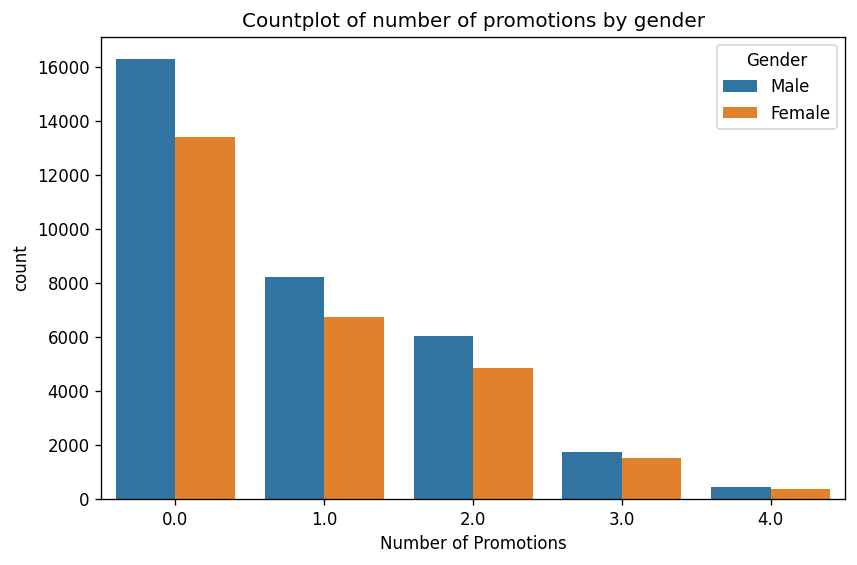

In [13]:
plt.figure(figsize=(8, 5), dpi=120)
plt.title("Countplot of number of promotions by gender")
sns.countplot(train_df, x='Number of Promotions', hue='Gender');

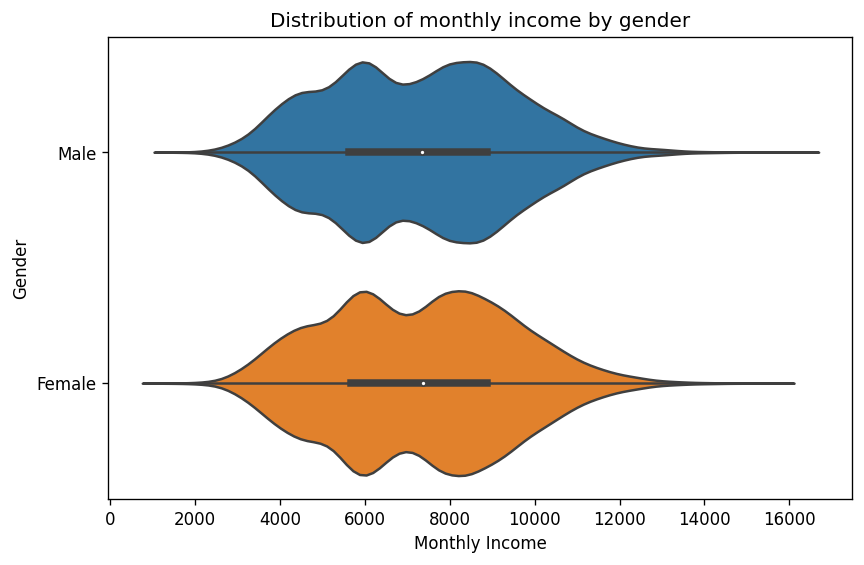

In [14]:
plt.figure(figsize=(8, 5), dpi=120)
plt.title("Distribution of monthly income by gender")
sns.violinplot(train_df, x='Monthly Income', y='Gender');

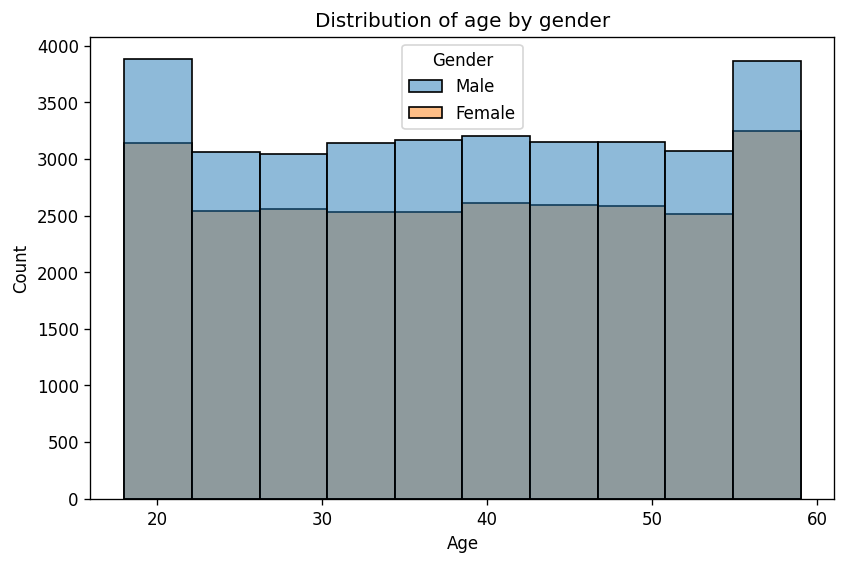

In [15]:
plt.figure(figsize=(8, 5), dpi=120)
plt.title("Distribution of age by gender")
sns.histplot(train_df, x='Age', hue='Gender', bins=10);

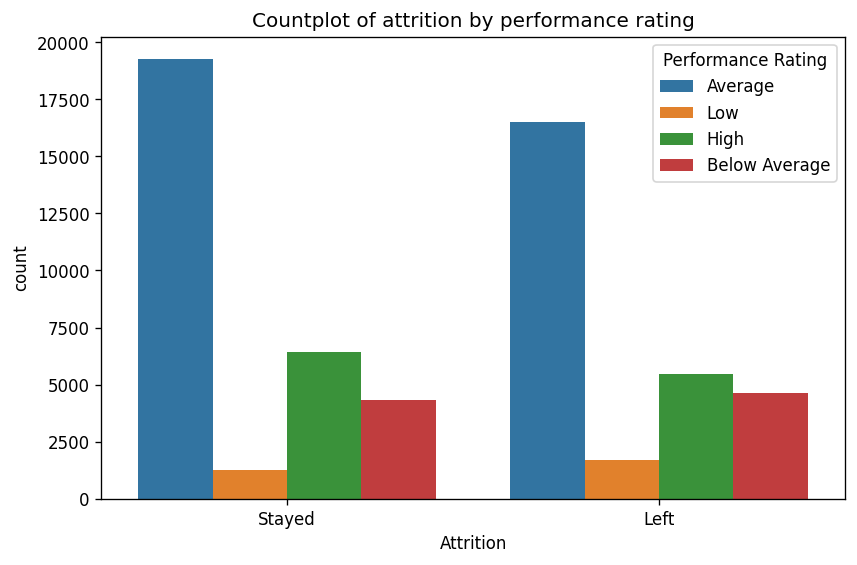

In [16]:
plt.figure(figsize=(8, 5), dpi=120)
plt.title("Countplot of attrition by performance rating")
sns.countplot(train_df, x='Attrition', hue='Performance Rating');

In [17]:
def check_missing_values(dataframe):
    """
    This function checks if the columns of the specified dataframe has any missing values or not. If any of the column
    has missing values, this function will print that column along with the number of missing values in that column.
    Args:
        dataframe = The dataset for whose columns you want to check the missing values
    """
    missing_values = False
    for col in dataframe.columns:
        if dataframe[col].isnull().sum() != 0:
            missing_values = True
            dataframe[col].isnull().sum()
    if missing_values == False:
        print(f"No missing values.")

In [18]:
check_missing_values(train_df)

No missing values.


# Data Preprocessing

In [19]:
scaler = MinMaxScaler()

def encode_and_transform(dataframe, train_data=True):
    """
    This function takes in a dataframe and applies the following transformations on its columns:
    1. If the dataframe belongs to the training set then the fit_transform() method of the MinMaxScaler will be used on its columns.
    2. If the dataframe belongs to the test set, only the transform() method of the MinMaxScaler will be used.
    3. If a categorical column has two unique values, those values will be mapped to 0 and 1.
    4. If a categorical column has more than k unique values (k>2), k binary features will be created out of that column.
    """
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype == float]
    cat_cols_3_or_more = [col for col in dataframe.columns if dataframe[col].dtype == object and dataframe[col].nunique() > 2]
    cat_cols_2 = [col for col in dataframe.columns if dataframe[col].dtype == object and dataframe[col].nunique() == 2]
    
    if train_data:
        dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])
    else:
        dataframe[num_cols] = scaler.transform(dataframe[num_cols])
        
    dataframe = pd.get_dummies(dataframe, columns=cat_cols_3_or_more, dtype=int)
    
    for col in cat_cols_2:
        vals = list(dict(dataframe[col].value_counts()).keys())
        mapping = {vals[0]: 0, vals[1]: 1}
        dataframe[col] = dataframe[col].map(mapping)
    
    return dataframe

In [20]:
train_df_transformed = encode_and_transform(train_df)
train_df_transformed

,Age,Gender,Years at Company,Monthly Income,Number of Promotions,Overtime,Distance from Home,Number of Dependents,Company Tenure,Remote Work,...,Company Size_Medium,Company Size_Small,Company Reputation_Excellent,Company Reputation_Fair,Company Reputation_Good,Company Reputation_Poor,Employee Recognition_High,Employee Recognition_Low,Employee Recognition_Medium,Employee Recognition_Very High
0,0.317073,0,0.36,0.274658,0.50,0,0.214286,0.000000,0.690476,0,...,1,0,1,0,0,0,0,0,1,0
1,1.000000,1,0.06,0.284366,0.75,0,0.204082,0.500000,0.150794,0,...,1,0,0,1,0,0,0,1,0,0
2,0.146341,1,0.18,0.461336,0.00,0,0.102041,0.500000,0.571429,0,...,1,0,0,0,0,1,0,1,0,0
3,0.439024,1,0.12,0.180206,0.25,0,0.265306,0.333333,0.380952,1,...,0,1,0,0,1,0,0,0,1,0
4,0.926829,0,0.80,0.236297,0.00,1,0.714286,0.000000,0.523810,0,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59593,0.780488,1,0.22,0.208859,0.25,1,0.663265,0.333333,0.261905,0,...,0,1,0,0,0,1,0,0,0,1
59594,0.000000,0,0.06,0.453314,0.75,0,0.418367,0.000000,0.563492,0,...,1,0,0,1,0,0,0,0,1,0
59595,0.097561,1,0.26,0.446842,0.00,1,0.336735,0.333333,0.214286,0,...,0,1,0,0,1,0,0,0,1,0
59596,0.121951,0,0.14,0.108879,0.00,0,0.622449,0.000000,0.055556,0,...,0,0,0,0,1,0,0,1,0,0


In [21]:
test_df_transformed = encode_and_transform(test_df, train_data=False)
test_df_transformed

,Age,Gender,Years at Company,Monthly Income,Number of Promotions,Overtime,Distance from Home,Number of Dependents,Company Tenure,Remote Work,...,Company Size_Medium,Company Size_Small,Company Reputation_Excellent,Company Reputation_Fair,Company Reputation_Good,Company Reputation_Poor,Employee Recognition_High,Employee Recognition_Low,Employee Recognition_Medium,Employee Recognition_Very High
0,0.439024,0,0.24,0.452572,0.25,1,0.836735,0.166667,0.158730,0,...,0,0,0,0,0,1,0,0,1,0
1,0.414634,0,0.12,0.218904,0.25,1,0.551020,0.666667,0.198413,0,...,1,0,0,0,1,0,1,0,0,0
2,0.780488,0,0.12,0.287669,0.75,1,0.132653,0.333333,0.587302,0,...,1,0,0,0,1,0,0,1,0,0
3,0.975610,0,0.86,0.283759,0.00,1,0.428571,0.666667,0.746032,0,...,1,0,0,0,0,1,0,1,0,0
4,0.512195,0,0.46,0.221668,0.00,1,0.469388,1.000000,0.341270,1,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14895,0.926829,1,0.82,0.439156,0.00,1,0.397959,0.000000,0.460317,0,...,1,0,0,0,0,1,0,0,1,0
14896,0.292683,1,0.28,0.171240,0.50,1,0.448980,0.000000,0.142857,0,...,1,0,0,0,1,0,0,0,1,0
14897,0.829268,0,0.08,0.292456,0.00,0,0.030612,0.666667,0.039683,0,...,0,1,0,0,1,0,1,0,0,0
14898,0.000000,0,0.06,0.266972,0.00,0,0.122449,0.500000,0.023810,0,...,0,0,0,0,0,1,1,0,0,0


# Train-test-validation split

In [22]:
X_train = train_df_transformed.drop("Attrition", axis=1)
y_train = train_df_transformed['Attrition']

In [23]:
X_test = test_df_transformed.drop("Attrition", axis=1)
y_test = test_df_transformed['Attrition']
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

# Model training and evaluation

In [24]:
model = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.05,
    reg_lambda=1,
    scale_pos_weight=1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
)

model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [25]:
preds = model.predict(X_test)
score = accuracy_score(y_test, preds)
print(f"The model accuracy on the test dataset is {round(score, 3)*100}%.")

The model accuracy on the test dataset is 76.2%.


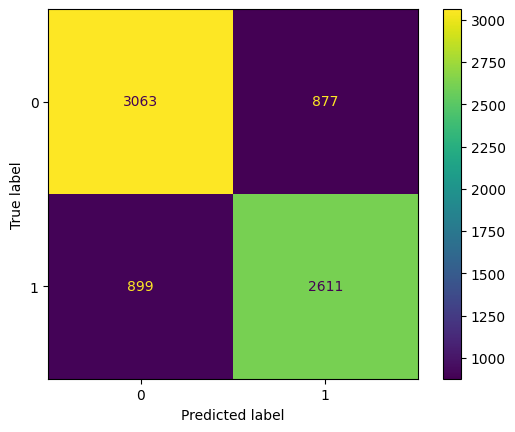

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();